<a href="https://colab.research.google.com/github/MaartenCVonk/Causal-Modeling/blob/main/Application_COM_estimation_to_obtain_ATE_in_back_door_case_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Summary**

This Notebook aims to calculate the causal effect of (binary) Treatment $T$ on outcome $Y$ with common observable confounder $Z$. We use Pearls axiomization for do-calculus to prove identifiability of outcome variable and use a scikit learn linear regression to apply a conditional outcome model (COM).

In [26]:
!pip install dowhy &> /dev/nul
!pip install git+git://github.com/mkrphys/ipython-tikzmagic.git &> /dev/nul

In [2]:
import dowhy
import seaborn as sns
import numpy as np
import pandas as pd
import dowhy.api
import matplotlib.pyplot as plt
%load_ext tikzmagic

## **Problem Setup:**


Suppose we have $N$ datapoints with covariates $Z$ where $Z$ is uniformly distributed between $[0,1]$: $z \sim U(0,1)$. Treatment $T$ has binomial distribution $t \sim B(1,\frac{1}{1+e^{-5z}})$. Also suppose we have outcome based on covariate $Z$ and treatment $T$: $y\sim 2z+t+0.1\mathcal{N}(0,1)$

In [27]:
#The causal graph depicted this situation
#%%tikz
#\draw (0,0) rectangle (1,1);
#\filldraw (0.5,0.5) circle (.1);


![picture](https://drive.google.com/uc?export=view&id=1uuH89vkXM1hy9KlPooHVuni7XPUtAwTS)


In [28]:
N = 5000

z = np.random.uniform(size=N)
t = np.random.binomial(1., p=1./(1. + np.exp(-5. * z)))
y = 2. * z + t + 0.1 * np.random.normal(size=N)

df = pd.DataFrame({'Z': z, 'T': t, 'Y': y})


Then the data looks like this:

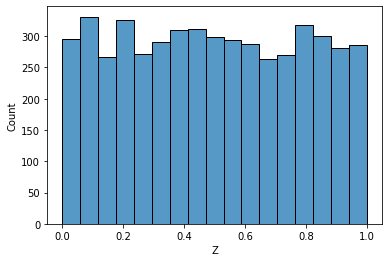

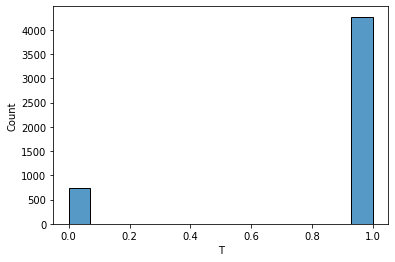

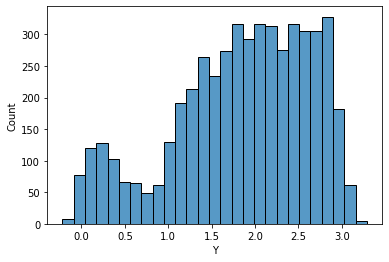

In [29]:
sns.histplot(df['Z'])
plt.show()
sns.histplot(df['T'])
plt.show()
sns.histplot(df['Y'])
plt.show()

If we compare the outcomes based on Treatment without taking into account the covariates, we do it in this naive way:

In [30]:
#Naive effect of T on Y:
(df[df['T'] == 1].mean() - df[df['T'] == 0].mean())['Y']

## **Preliminaries and Identification**

This is not the causal effect, since $Z$ confounds the relation between $T$ and $Y$. We create a model that accounts for the intervention distribution $P(Y|do(T=t))$, but we first start with a complete axiomization of the do-calculus to account for the steps in the model created.

**Pearls Do-Calcus Rules:**

Let $G$ be the DAG associated with a causal model and let $P()$ be  the probability distribution induced by that model. For any disjoinst subsets of variables $X,Y,Z,W$ we have the following rules:

**Rule 1: $ $** 
$P(y|do(x),z,w) = P(y|do(x),w)$ if $((Y\perp \!\!\! \perp Z)|X,W)_{G_\overline{X}}$

**Rule 2: $ $** 
$P(y|do(x),do(z),w) = P(y|do(x),z,w)$ if $((Y\perp \!\!\! \perp Z)|X,W)_{G_{\overline{X}\underline{Z}}}$

**Rule 3: $ $** 
$P(y|do(x),do(z),w) = P(y|do(x),w)$ if $((Y\perp \!\!\! \perp Z)|X,W)_{G_{\overline{X}\overline{Z(W)}}}$

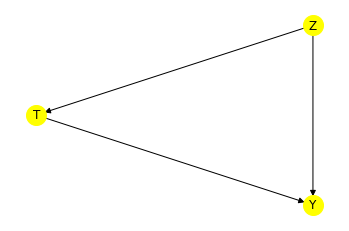

In [31]:
#Create Causal Model:
from dowhy import CausalModel

causes = ['T']
outcomes = ['Y']
common_causes = ['Z']

model = CausalModel(df,
                    causes,
                    outcomes,
                    common_causes=common_causes)

# Let Dowhy plot the model just for verification purposes:
model.view_model(layout="dot")

We first want to know if we can identify $Y$ given cause $T$ and common cause $Z$. From *Causal Diagrams and the Identification of Causal Effects* (Pearl,200), we obtain the following theorem: 

**Theorem:**
A causal effect $q = P(y_1, … , y_k |do(t_1), … ,do(t_n))$ is identifiable in a model characterized
by a graph $G$ if there exists a finite sequence of transformations, each conforming to one
of the inference rules above, that reduces $q$ into a standard (i.e., “do-operator”-free)
probability expression involving observed quantities.

We can now prove that in our causal graph, $Y$ is identifiable by treatment $T$. First we marginalize out $z$ by rules of probability:
\begin{align}
P(Y|do(T=t))=\sum_{z}P(y|z,do(t))P(z|do(t))
\end{align}
Now we we observe that $((Y\perp \!\!\! \perp T)|Z)_{G_{\underline{T}}}$ and we apply the second rule of do-calculus to rewrite te first term:

\begin{align}
P(y|z,do(t))=P(y|z,t).
\end{align}

Similarly, we observe that  $(Z\perp \!\!\! \perp T)_{G_{\overline{T}}}$ to apply the third rule of do-calculus to obtain

\begin{align}
P(z|do(t))=P(z).
\end{align}

We can rewrite our first expression than to:
\begin{align}
P(Y|do(T=t))=\sum_{z}P(y|z,t)P(z).
\end{align}

Since the last expression is 'do-operator free', this is now an application of the do-calculus to prove identifiability. In this case the identifiablility is called the **back-door theorem.** Dowhy can also check identifiablity. We check if Dowhy is also able to identify the $Y$.

In [32]:
# Check if the variable can be identified:
identification = model.identify_effect()
identification

## **From Identifiability to Estimation**

Note that we want to know thanks to the back-door theorem:


\begin{align} 
P(y|do(T=t))&=\sum_{z}P(y|t,z)P(z)
\end{align}
but we are after the causal effect of $T$ on $Y$, so we are after $\mathbb{E}(Y\mid do(T=1))-\mathbb{E}(Y\mid do(T=0))$, so using the backdoor theorem we can rewrite this to:

\begin{align*}
\mathbb{E}(Y\mid do(T=1))-\mathbb{E}(Y\mid do(T=0))=\mathbb{E}_Z(\mathbb{E}(Y\mid T=1, Z))-\mathbb{E}(Y\mid T=0, Z)).
\end{align*}

So we can use any sort of model $\hat \mu$ to estimate the conditional expectation and then appromiate the outer expectation by taking the sample mean:
\begin{align*}
\mathbb{E}(Y\mid do(T=1))-\mathbb{E}(Y\mid do(T=0))=\mathbb{E}_Z(\mathbb{E}(Y\mid T=1, Z)-\mathbb{E}(Y\mid T=0, Z))=\frac{1}{n}\sum_{i}^n \hat \mu(1,z_i)-\hat \mu(0,z_i).
\end{align*}



In [35]:
# We can fit any sort of model: we try a simple linear regression.
from sklearn.linear_model import LinearRegression

X=np.array(df[['T','Z']]) #Note that mu depends on T and Z in our example.
mu = LinearRegression().fit(X, np.array(df['Y']))

#Estimate the inner expectations
estimation = mu.predict(list(zip(np.ones(5000),df['Z'])))-mu.predict(list(zip(np.zeros(5000),df['Z'])))

# And then the outer expectation to calculate the causal effect.
estimation.mean()